In [21]:
import os
from PIL import Image
import glob
import urllib.request
import datasets
from datasets import load_dataset, Dataset
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import SubplotSpec
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

In [22]:
print(os.getcwd())

/scratch/yg2709/CSCI-SHU-360-Machine-Learning-Final-Project/Playground


In [23]:
if not os.path.exists("mini_classes.txt"):
    os.system("wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'")


f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [24]:
def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in tqdm(classes):        
        cls_url = c.replace('_', '%20')
        path = base+cls_url+'.npy'
        # print(path)
        urllib.request.urlretrieve(path, 'scribble_data/'+c+'.npy')

In [25]:
if not os.path.exists('scribble_data'):
    os.makedirs('scribble_data')
    download()
else:
    print('scribble_data already exists')

scribble_data already exists


In [26]:
max_items_per_class = 20
def load_data_for_diffusion(root, max_items_per_class= max_items_per_class ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables
    imgs = np.empty([0, 784])
    labels = []

    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]

        class_name, ext = os.path.splitext(os.path.basename(file))
        labels.extend(["a scribble of " + class_name for i in range(data.shape[0])])

        imgs = np.concatenate((imgs, data), axis=0)


    return imgs, labels

In [27]:
imgs, labels = load_data_for_diffusion('scribble_data')

In [28]:
def gen_for_hf(imgs, labels):
    for idx in range(len(imgs)):
        img = Image.fromarray(imgs[idx].reshape(28,28))
        label = labels[idx]
        yield {"image": img, "text": label}

scribble_dataset = Dataset.from_generator(gen_for_hf, gen_kwargs={"imgs": imgs, "labels": labels})
scribble_dataset = scribble_dataset.shuffle(seed=1000)

Found cached dataset generator (/home/yg2709/.cache/huggingface/datasets/generator/default-1c9c755726a24521/0.0.0)


In [44]:
train_transforms = transforms.Compose(
    [
        transforms.Resize(512, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.RandomHorizontalFlip(),
        transforms.RandomInvert(p=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def preprocess_train(examples):
    images = [image.convert("RGB") for image in examples["image"]]
    examples["pixel_values"] = [train_transforms(image) for image in images]
#     examples["input_ids"] = tokenize_captions(examples)
    return examples

In [45]:
train_dataset = scribble_dataset.with_transform(preprocess_train)

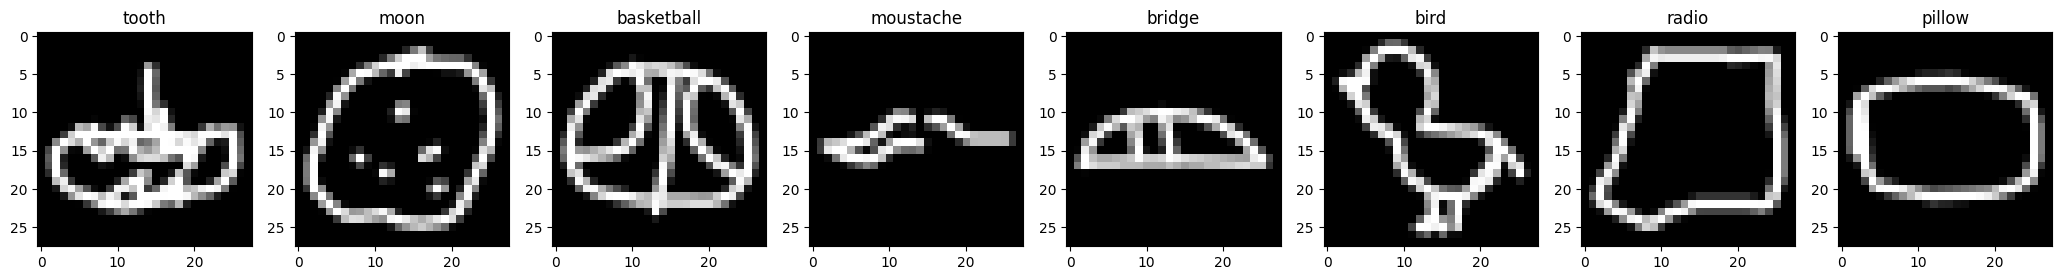

In [53]:
imgs = scribble_dataset['image'][0:8]
type(imgs)

nrow, ncol = 1, len(imgs)
fig, axs = plt.subplots(nrow, ncol, figsize=(2*ncol+10, 2*nrow+2))

for c in range(ncol):
    
    ax = axs[c]
    ax.set_title(scribble_dataset['text'][c].replace('a scribble of ', ''))
    ax.imshow(imgs[c])

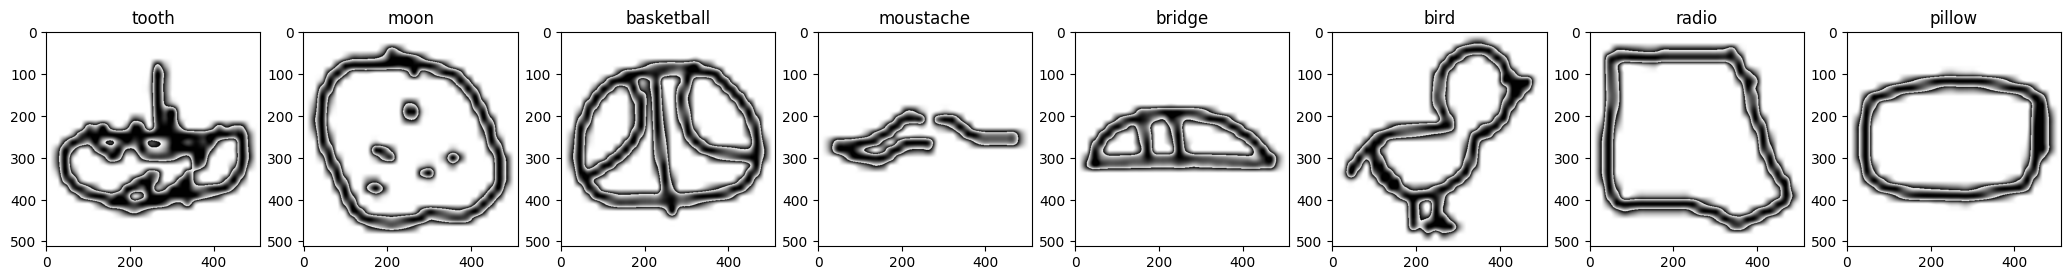

In [52]:
train_dataset
imgs = train_dataset[0:8]['pixel_values']
type(imgs[0])

nrow, ncol = 1, len(imgs)
fig, axs = plt.subplots(nrow, ncol, figsize=(2*ncol+10, 2*nrow+2))

for c in range(ncol):
    img_tensor = imgs[c]
    transform = transforms.ToPILImage()
    img = transform(img_tensor)
    ax = axs[c]
    ax.set_title(scribble_dataset['text'][c].replace('a scribble of ', ''))
    ax.imshow(img)